### Variational Classifier  example 1  : integer --> binary class
Based on https://pennylane.ai/qml/demos/tutorial_variational_classifier/

In [8]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt
qcstyle="black_white"

dev = qml.device("default.qubit")

In [28]:
# define a “layer” or “block”, which is an elementary circuit architecture that gets repeated 
def layer(layer_weights):
    for wire in range(4):
        #print('ww',wire,*layer_weights[wire].shape)
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

# It expects x to be a list of zeros and ones, i.e. [0,1,0,1].
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])


In [3]:
# define the variational quantum circuit as this state preparation routine, followed by a repetition of the layer structure.
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [33]:
# test circuit assembly
np.random.seed(0)
num_qubits = 4
num_layers = 2
num_u3_ang= 3  # const
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, num_u3_ang, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)
x0 = [0, 1, 0, 1]

print("Weights:", weights_init.shape)
print("Bias: ", bias_init)
print("X0: ", x0)

Weights: (2, 4, 3)
Bias:  0.0
X0:  [0, 1, 0, 1]


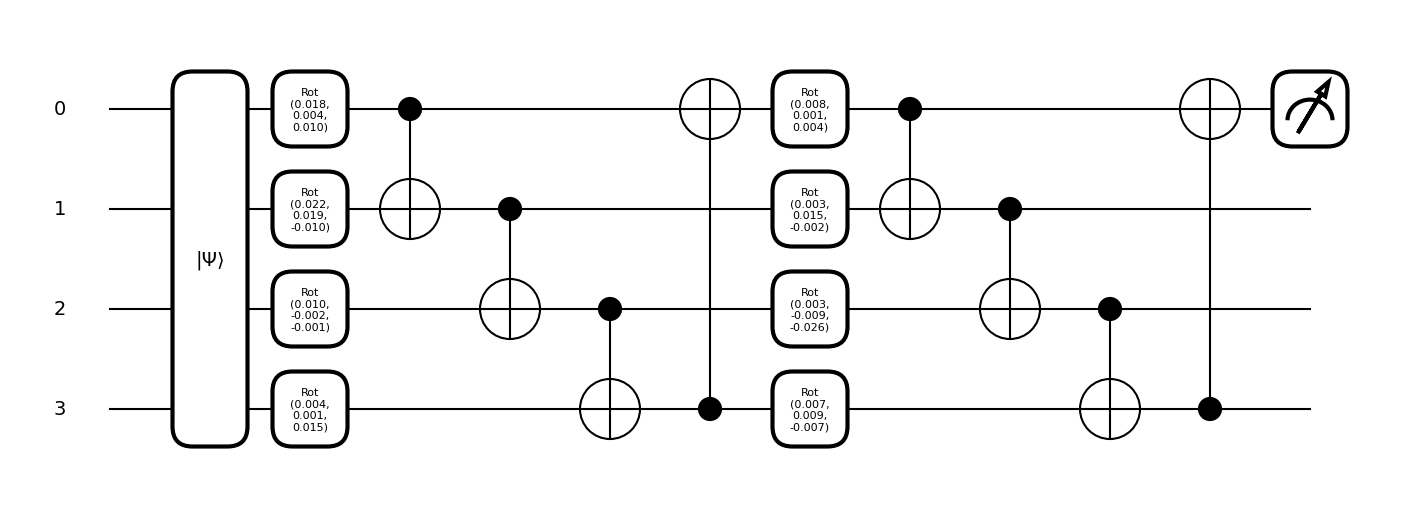

In [34]:
qml.draw_mpl(circuit, decimals=3, style=qcstyle)(weights_init,x0)
plt.show()

In [31]:
# add ML  computational elements

# bias is added classically
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

#  COST
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

#  ACCURACY
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [32]:
#  parity dataset’s train and test sets can be downloaded and should be placed in the subfolder data/
data = np.loadtxt("data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


In [38]:
#  TRAIN
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    if it%3==0 : print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 2.9571746 | Accuracy: 0.5000000
Iter:    4 | Cost: 1.0740691 | Accuracy: 0.4000000
Iter:    7 | Cost: 0.9739360 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.6268841 | Accuracy: 0.6000000
Iter:   13 | Cost: 1.3338699 | Accuracy: 0.5000000
Iter:   16 | Cost: 1.5351840 | Accuracy: 0.8000000
Iter:   19 | Cost: 0.8585531 | Accuracy: 0.6000000
Iter:   22 | Cost: 0.0644022 | Accuracy: 1.0000000
Iter:   25 | Cost: 0.0360464 | Accuracy: 1.0000000
Iter:   28 | Cost: 0.0160045 | Accuracy: 1.0000000
Iter:   31 | Cost: 0.0067503 | Accuracy: 1.0000000
Iter:   34 | Cost: 0.0033795 | Accuracy: 1.0000000
Iter:   37 | Cost: 0.0022075 | Accuracy: 1.0000000
Iter:   40 | Cost: 0.0015374 | Accuracy: 1.0000000
Iter:   43 | Cost: 0.0010841 | Accuracy: 1.0000000
Iter:   46 | Cost: 0.0002512 | Accuracy: 1.0000000
Iter:   49 | Cost: 0.0001792 | Accuracy: 1.0000000
Iter:   52 | Cost: 0.0001449 | Accuracy: 1.0000000
Iter:   55 | Cost: 0.0001065 | Accuracy: 1.0000000
Iter:   58 | Cost: 0.0000864 | 

In [37]:
#  VALIDATE
data = np.loadtxt("data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0
